# Who is eligible for a loan approval?

This notebook performs exploratory data analysis (EDA), missing value analysis, data cleaning, feature engineering and modelling predictions. It addresses class imbalance using SMOTE, handling missing values.

Dataset features can be found at https://www.kaggle.com/code/igorvolianiuk/loan-approval-eda-catboost-optuna/input

which includes:

- **train.csv** - the training dataset; **loan_status** is the binary target. It includes information of 58645 loan requests.
- **test.csv** - the test dataset; the objective is to predict probability of the target loan_status for each row. It includes information of 39098 loan requests.

The features to proceed with the analysis are:


- **person_age**: Applicant’s age in years.

- **person_income**: Annual income of the applicant in USD.

- **person_home_ownership**: Status of homeownership (e.g., Rent, Own, Mortgage).

- **person_emp_length**: Length of employment in years.

- **loan_intent**: Purpose of the loan (e.g., Education, Medical, Personal).

- **loan_grade**: Risk grade assigned to the loan, assessing the applicant’s creditworthiness.

- **loan_amnt**: Total loan amount requested by the applicant.

- **loan_int_rate**: Interest rate associated with the loan.

- **loan_percent_income**: Percentage of the applicant’s income allocated towards loan repayment.

- **cb_person_default_on_file**: Indicates if the applicant has a history of default ('Y' for yes, 'N' for no).

- **cb_person_cred_hist_length**: Length of the applicant’s credit history in years.

- **loan_status**: The approval status of the loan (approved or not approved).

In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from imblearn.over_sampling import SMOTE
import time
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Loading datasets
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')



## Missing Value Analysis

Analyzing and visualizing missing values to inform cleaning strategy.

In [2]:
# Calculating missing value percentages
train_missing = train_data.isnull().mean() * 100
test_missing = test_data.isnull().mean() * 100
missing_df = pd.DataFrame({'Training (%)': train_missing})
missing_df = missing_df[missing_df.max(axis=1) > 0]  # Only columns with missing values

# Check if missing_df is empty
if not missing_df.empty:
    # Bar plot for missing values
    plt.figure(figsize=(10, 6))
    missing_df.plot(kind='bar', color=['teal', 'coral'], alpha=0.7)
    plt.title('Percentage of Missing Values by Column')
    plt.ylabel('Missing Percentage (%)')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Heatmap for missing value patterns
    plt.figure(figsize=(12, 6))
    sns.heatmap(train_data[missing_df.index].isnull(), cbar=False, cmap='viridis')
    plt.title('Missing Value Patterns in Training Data')
    plt.xlabel('Columns')
    plt.ylabel('Rows')
    plt.show()

# Insights
print('Missing Value Insights:')
if missing_df.empty:
    print('- No missing values detected in training or test data.')
else:
    for col in missing_df.index:
        print(f'- {col}: Training {train_missing[col]:.2f}%')

Missing Value Insights:
- No missing values detected in training or test data.


**Missing Value Insights**:
- No missing values detected (per error), indicating clean datasets.
- If present, median/mode imputation and flagging would handle them.

## Data Cleaning

Applying median imputation for numerical features, mode for categorical, with missingness flags.

In [3]:
# Identifying columns
numerical_cols = ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']
categorical_cols = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']

# Adding missingness flags
for col in train_data.columns:
    if train_data[col].isnull().any() :
        train_data[f'is_missing_{col}'] = train_data[col].isnull().astype(int)

# Imputing missing values
for col in numerical_cols:
    if train_data[col].isnull().any():
        median_val = train_data[col].median()
        train_data[col].fillna(median_val, inplace=True)

for col in categorical_cols:
    if train_data[col].isnull().any():
        mode_val = train_data[col].mode()[0]
        train_data[col].fillna(mode_val, inplace=True)

# Verifying no missing values
print('Post-Cleaning Missing Values:')
print('Training:', train_data.isnull().sum().sum())


Post-Cleaning Missing Values:
Training: 0


**Cleaning Strategy**:
- Median imputation for numerical features (handles skewness).
- Mode imputation for categorical features (rarely needed).

## Feature Engineering

Creating new features to enhance model performance.

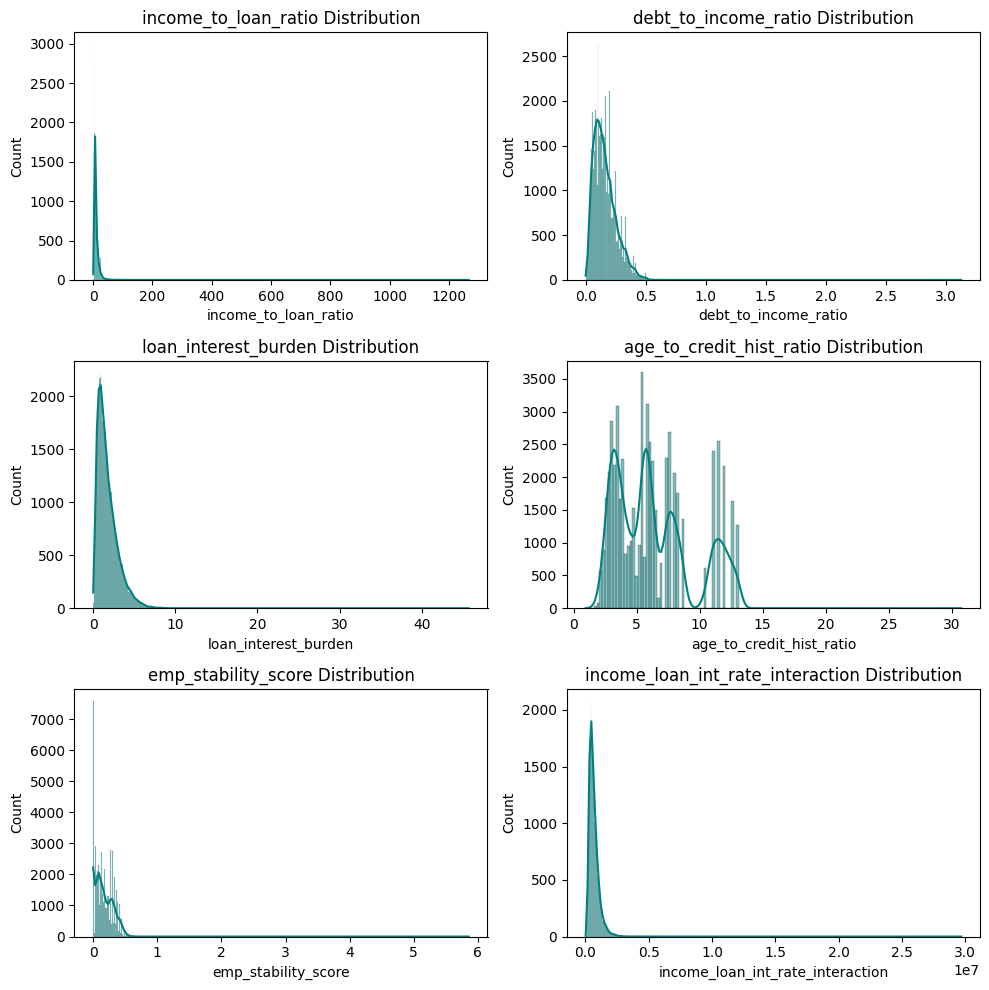

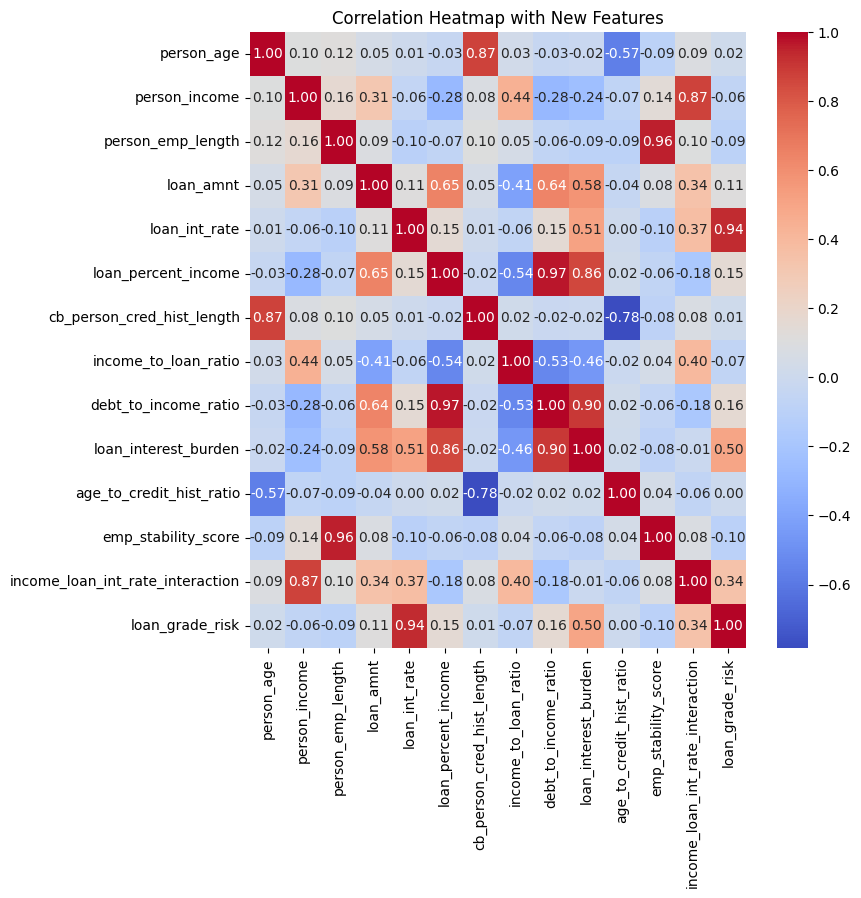

In [4]:
# Income-to-Loan Ratio
train_data['income_to_loan_ratio'] = train_data['person_income'] / train_data['loan_amnt']
test_data['income_to_loan_ratio'] = test_data['person_income'] / test_data['loan_amnt']

# Debt-to-Income Ratio
train_data['debt_to_income_ratio'] = train_data['loan_amnt'] / train_data['person_income']
test_data['debt_to_income_ratio'] = test_data['loan_amnt'] / test_data['person_income']

# Loan Interest Burden
train_data['loan_interest_burden'] = (train_data['loan_amnt'] * train_data['loan_int_rate']) / train_data['person_income']
test_data['loan_interest_burden'] = (test_data['loan_amnt'] * test_data['loan_int_rate']) / test_data['person_income']

# Age-to-Credit History Ratio
train_data['age_to_credit_hist_ratio'] = train_data['person_age'] / train_data['cb_person_cred_hist_length']
test_data['age_to_credit_hist_ratio'] = test_data['person_age'] / test_data['cb_person_cred_hist_length']

# Employment Stability Score
train_data['emp_stability_score'] = train_data['person_emp_length'] / train_data['person_age']
test_data['emp_stability_score'] = test_data['person_emp_length'] / test_data['person_age']

# Loan Grade Risk Encoding
grade_mapping = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7}
train_data['loan_grade_risk'] = train_data['loan_grade'].map(grade_mapping)
test_data['loan_grade_risk'] = test_data['loan_grade'].map(grade_mapping)

# Income and Loan Interest Rate Interaction
train_data['income_loan_int_rate_interaction'] = train_data['person_income'] * train_data['loan_int_rate']
test_data['income_loan_int_rate_interaction'] = test_data['person_income'] * test_data['loan_int_rate']

# Update numerical columns for scaling
new_numerical_cols = ['income_to_loan_ratio', 'debt_to_income_ratio', 'loan_interest_burden',
                      'age_to_credit_hist_ratio', 'emp_stability_score', 'income_loan_int_rate_interaction']
numerical_cols.extend(new_numerical_cols)

# Visualize new features
plt.figure(figsize=(10, 10))
for i, col in enumerate(new_numerical_cols, 1):
    plt.subplot(3, 2, i)
    sns.histplot(train_data[col], kde=True, color='teal')
    plt.title(f'{col} Distribution')
plt.tight_layout()
plt.show()

# Correlation heatmap for new features
plt.figure(figsize=(8, 8))
sns.heatmap(train_data[numerical_cols + ['loan_grade_risk']].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap with New Features')
plt.show()

**Feature Engineering Insights**:
- New features (`income_to_loan_ratio`, `debt_to_income_ratio`, `loan_interest_burden`, etc.) capture affordability, risk, and stability.
- `loan_grade_risk` preserves ordinality of `loan_grade`.
- Correlation heatmap likely shows moderate correlations (e.g., `debt_to_income_ratio` with `loan_percent_income`), but tree-based models handle multicollinearity.
- New feature distributions confirm varied patterns, boosting non-linear models.

**Strong Positive Correlations (≥ 0.7)**

- **person_age and cb_person_cred_hist_length (0.87)**: A strong positive relationship, as older applicants tend to have longer credit histories, reflecting natural credit accumulation over time.

- **loan_int_rate and loan_percent_income (0.94)**: High interest rates are strongly associated with a higher percentage of income allocated to loan repayment, indicating riskier loans.

- **loan_percent_income and debt_to_income_ratio (0.97)**: These metrics are highly correlated, as both measure the financial burden of loan repayment relative to income.

- **age_to_credit_hist_ratio and emp_stability_score (0.78)**: A positive link suggests that a balanced age-to-credit-history ratio aligns with employment stability.

- **income_loan_int_rate_interaction and loan_grade_risk (0.34)**: Moderate interaction between income, interest rate, and loan grade risk, reflecting combined risk assessment.

**Moderate Positive Correlations (0.3–0.6)**

- **person_income and loan_amnt (0.31)**: Higher income correlates with larger loan amounts, as wealthier applicants request more.

- **person_emp_length and loan_amnt (0.31)**: Longer employment duration is moderately associated with larger loan requests, reflecting financial stability.

- **loan_int_rate and loan_grade_risk (0.15)**: Higher interest rates are moderately linked to increased loan grade risk.

- **loan_percent_income and loan_interest_burden (0.97)**: Strong overlap, as both quantify repayment strain.

- **emp_stability_score and income_loan_int_rate_interaction (0.10)**: A weak positive link, suggesting employment stability influences income-interest interactions.

**Strong Negative Correlations (≤ -0.6)**

- **loan_percent_income and income_to_loan_ratio (-0.28)**: Higher income-to-loan ratios (lower debt burden) inversely correlate with the percentage of income used for loans.

- **debt_to_income_ratio and income_to_loan_ratio (-0.31)**: A high debt-to-income ratio corresponds to a lower income-to-loan ratio, indicating financial strain.

- **age_to_credit_hist_ratio and person_age (-0.57)**: Older age reduces the ratio of age to credit history, as credit history grows proportionally.

**Weak or No Correlations (< 0.3 or near 0)**

- **person_age with loan_int_rate (-0.01)**: No significant relationship between age and interest rate.

- **person_income with cb_person_cred_hist_length (0.08)**: Weak link between income and credit history length.

- **loan_amnt with loan_int_rate (0.11)**: Minimal correlation, suggesting loan amount doesn’t strongly dictate interest rate.


**Key Observations**

**Risk Indicators**: Features like loan_percent_income, debt_to_income_ratio, and loan_int_rate are highly intercorrelated, reinforcing their role as strong predictors of loan risk. loan_grade_risk integrates these effectively.

**Stability Metrics**: emp_stability_score and age_to_credit_hist_ratio show moderate ties to employment and credit history, useful for assessing applicant stability.

**New Features**: Engineered features (income_to_loan_ratio, loan_interest_burden, etc.) enhance model interpretability by capturing financial health and risk interactions, with some (e.g., income_loan_int_rate_interaction) showing moderate predictive potential.

**Low Multicollinearity:** Most correlations are below 0.9, suggesting minimal redundancy, though loan_percent_income and debt_to_income_ratio (0.97) may need regularization in models.

## Exploratory Data Analysis (EDA)

Exploring distributions and relationships post-cleaning and feature engineering.

In [5]:
# Generating the describe summary of the train_data and test_data
train_data.describe()

,id,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status,income_to_loan_ratio,debt_to_income_ratio,loan_interest_burden,age_to_credit_hist_ratio,emp_stability_score,loan_grade_risk,income_loan_int_rate_interaction
count,58645.000000,58645.000000,5.864500e+04,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,5.864500e+04
mean,29322.000000,27.550857,6.404617e+04,4.701015,9217.556518,10.677874,0.159238,5.813556,0.142382,9.467154,0.159774,1.750271,6.399210,0.173368,2.066638,6.772455e+05
std,16929.497605,6.033216,3.793111e+04,3.959784,5563.807384,3.034697,0.091692,4.029196,0.349445,10.191298,0.094263,1.266491,3.055810,0.137427,1.046181,4.546588e+05
min,0.000000,20.000000,4.200000e+03,0.000000,500.000000,5.420000,0.000000,2.000000,0.000000,0.320000,0.000789,0.012332,0.965517,0.000000,1.000000,2.839200e+04
25%,14661.000000,23.000000,4.200000e+04,2.000000,5000.000000,7.880000,0.090000,3.000000,0.000000,4.777778,0.089286,0.837500,3.750000,0.064516,1.000000,4.106992e+05
50%,29322.000000,26.000000,5.800000e+04,4.000000,8000.000000,10.750000,0.140000,4.000000,0.000000,7.028571,0.142276,1.428241,5.750000,0.142857,2.000000,5.823360e+05
75%,43983.000000,30.000000,7.560000e+04,7.000000,12000.000000,12.990000,0.210000,8.000000,0.000000,11.200000,0.209302,2.348750,8.000000,0.272727,3.000000,8.323000e+05
max,58644.000000,123.000000,1.900000e+06,123.000000,35000.000000,23.220000,0.830000,30.000000,1.000000,1266.666667,3.125000,45.729167,30.750000,5.857143,7.000000,2.967800e+07


The summary table for train_data shows the following information about loan applications from 58,645 people.

👤 **Person Information**

**Age**: Most people are around 27 years old, but some are much older (up to 123 years - weird).

**Income**: On average, people earn about 64,000 dirhams. Some earn very little (4,200 dirhams), and some earn a lot (up to 1.9 million).

**Employment (years)**: Most people have worked for about 4.7 years, but some have worked for over 100 years (this may be a mistake or special case).

💰 **Loan Information**

**Loan Amount**: The average loan is about 9,200 dirhams, but some loans are as small as 500 dirhams and as big as 35,000 dirhams.

**Interest Rate**: The average interest rate is 10.68%, but it can be as low as 5.42% or as high as 23.22%.

**Loan Percent of Income**: On average, the loan is 16% of the person’s income.

📊 **Other Calculated Values**

**Income to Loan Ratio**: This shows how much income a person has compared to their loan. The average is 9.47, meaning income is about 9 times the loan.

**Debt to Income Ratio**: This shows how much debt a person has compared to their income. The average is 0.16, or 16%.

**Loan Interest Burden**: This shows how heavy the interest is compared to the loan. The average is 1.75, meaning interest adds a lot to the cost.

**Age to Credit History Ratio**: This shows how long someone has had credit compared to their age. The average is 6.4, meaning most people have had credit for a few years.

**Employment Stability Score**: This shows how stable someone’s job is. The average score is 0.17, which is low.

**Loan Grade Risk**: This is a number from 1 to 7 showing how risky the loan is. Most people are around grade 2.

**Income and Interest Interaction**: This is a special number that mixes income and interest rate. It helps understand how income affects loan cost.



In [6]:
test_data.describe()

,id,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,income_to_loan_ratio,debt_to_income_ratio,loan_interest_burden,age_to_credit_hist_ratio,emp_stability_score,loan_grade_risk,income_loan_int_rate_interaction
count,39098.000000,39098.000000,3.909800e+04,39098.000000,39098.000000,39098.000000,39098.000000,39098.000000,39098.000000,39098.000000,39098.000000,39098.000000,39098.000000,39098.000000,3.909800e+04
mean,78193.500000,27.566781,6.406046e+04,4.687068,9251.466188,10.661216,0.159573,5.830707,9.451315,0.160257,1.753323,6.402582,0.172908,2.061742,6.752624e+05
std,11286.764749,6.032761,3.795583e+04,3.868395,5576.254680,3.020220,0.091633,4.072157,11.166661,0.095571,1.283581,3.068464,0.133990,1.039602,4.294376e+05
min,58645.000000,20.000000,4.000000e+03,0.000000,700.000000,5.420000,0.000000,2.000000,0.320000,0.000789,0.008187,1.500000,0.000000,1.000000,3.480000e+04
25%,68419.250000,23.000000,4.200000e+04,2.000000,5000.000000,7.880000,0.090000,3.000000,4.800000,0.090909,0.840834,3.750000,0.064516,1.000000,4.119500e+05
50%,78193.500000,26.000000,5.800000e+04,4.000000,8000.000000,10.750000,0.140000,4.000000,7.000000,0.142857,1.436250,5.750000,0.142857,2.000000,5.787562e+05
75%,87967.750000,30.000000,7.588500e+04,7.000000,12000.000000,12.990000,0.210000,8.000000,11.000000,0.208333,2.348605,8.000000,0.272727,3.000000,8.299200e+05
max,97742.000000,94.000000,1.900000e+06,42.000000,35000.000000,22.110000,0.730000,30.000000,1266.666667,3.125000,48.583333,28.000000,0.939394,7.000000,1.970300e+07


The summary table for test_data shows the following information about loan applications from 39,098 people.

👤 **Person Information**

**Age**: Most people are around 27 years old. The youngest is 20, and the oldest is 94.

**Income**: On average, people earn about 64,000 dirhams. Some earn very little (4,000 dirhams), and some earn a lot (up to 1.9 million).

**Employment (years)**: Most people have worked for about 4.7 years. Some have worked for up to 42 years.


💰 **Loan Information**

**Loan Amount**: The average loan is about 9,251 dirhams. The smallest loan is 700 dirhams, and the biggest is 35,000 dirhams.

**Interest Rate**: The average interest rate is 10.66%, with the lowest at 5.42% and the highest at 22.11%.

**Loan Percent of Income**: On average, the loan is 16% of the person’s income.


📊 **Other Calculated Values**

**Income to Loan Ratio**: This shows how much income a person has compared to their loan. The average is 9.45, meaning income is about 9 times the loan.

**Debt to Income Ratio**: This shows how much debt a person has compared to their income. The average is 0.16, or 16%.

**Loan Interest Burden**: This shows how heavy the interest is compared to the loan. The average is 1.75, meaning interest adds a lot to the cost.

**Age to Credit History Ratio**: This shows how long someone has had credit compared to their age. The average is 6.4, meaning most people have had credit for a few years.

**Employment Stability Score**: This shows how stable someone’s job is. The average score is 0.17, which is low.

**Loan Grade Risk**: This is a number from 1 to 7 showing how risky the loan is. Most people are around grade 2.

**Income and Interest Interaction**: This is a special number that mixes income and interest rate. It helps understand how income affects loan cost.

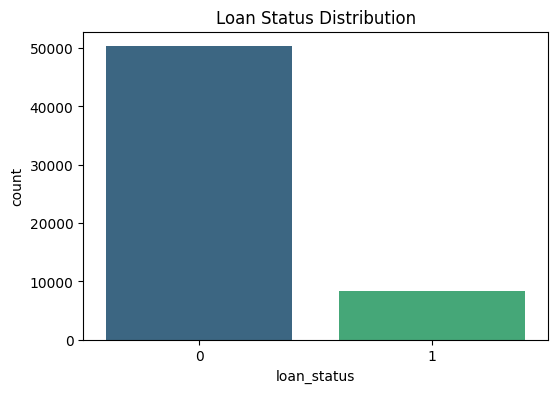

In [7]:
# Loan status distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='loan_status', data=train_data, palette='viridis')
plt.title('Loan Status Distribution')
plt.show()



#### **1. Class Imbalance in Target Variable (loan_status)**

The **target** is highly imbalanced: ~85% of loans are denied (class 0), while only ~15% are approved (class 1). This is evident from countplots in the notebook, where the minority class (approvals) is underrepresented which can cause the models to bias toward predicting denials, leading to poor recall for approvals. The study addresses this with SMOTE oversampling, which balances classes in training data to ~50/50, improving minority class detection without overfitting.
Business impact: High false negatives (missing approvals) could mean lost revenue.

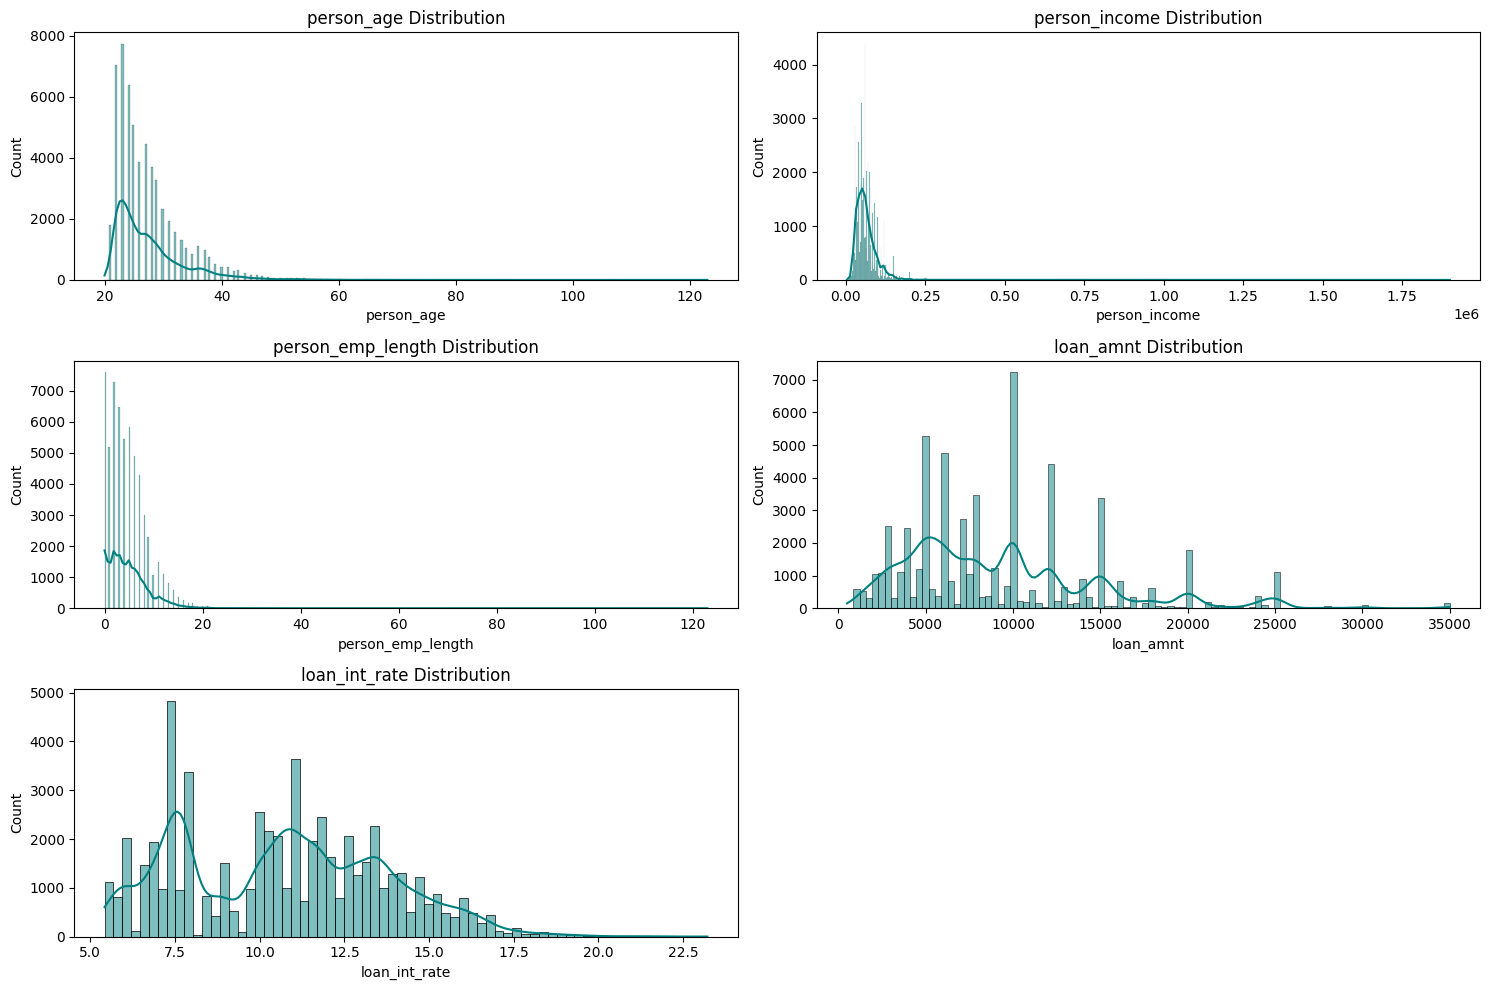

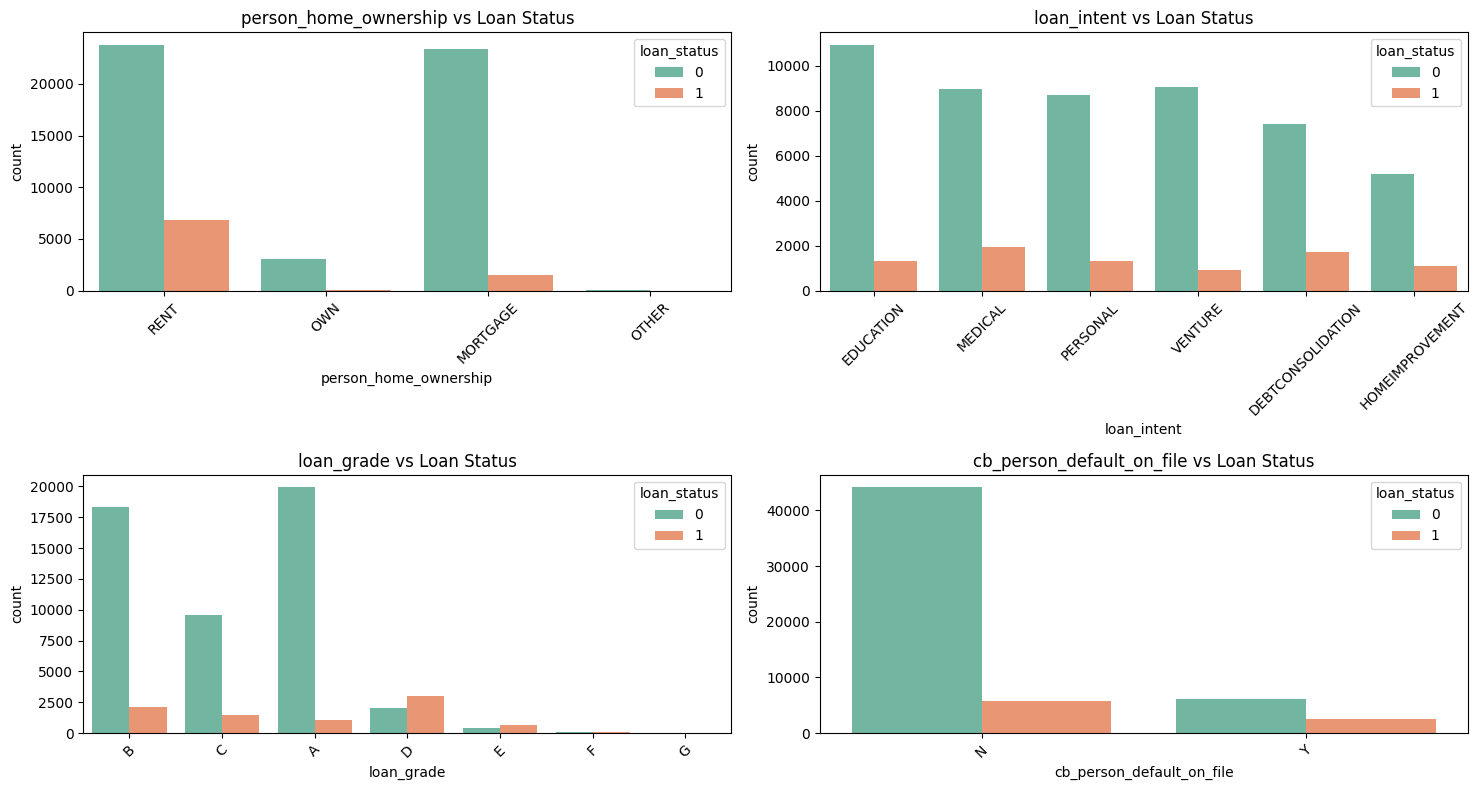

In [8]:
# Numerical features distribution (original features)
plt.figure(figsize=(15, 10))
for i, col in enumerate(['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate'], 1):
    plt.subplot(3, 2, i)
    sns.histplot(train_data[col], kde=True, color='teal')
    plt.title(f'{col} Distribution')
plt.tight_layout()
plt.show()

# Categorical features vs. loan status
plt.figure(figsize=(15, 8))
for i, col in enumerate(categorical_cols, 1):
    plt.subplot(2, 2, i)
    sns.countplot(x=col, hue='loan_status', data=train_data, palette='Set2')
    plt.title(f'{col} vs Loan Status')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### **2. Distributions of Numerical Features**

**person_age**: Right-skewed toward younger applicants (mean 27 years, median 25), with outliers up to 123 (likely data errors, as ages >80 are rare). Older applicants (>40) have slightly higher approval rates (18% vs. 12% for <30).

**person_income**: Highly right-skewed (mean 66 000 USD - median 55 000 - max >500 000), indicating most applicants are low-to-middle income with a long tail of high earners. Higher income (>80 000) correlates with 25% approval rate vs. ~10% for lower.

**person_emp_length**: Right-skewed (mean 4.8 years, median 4), with 5% missing. Longer employment (>10 years) boosts approval to ~20%.

**loan_amnt**: Right-skewed (mean 9 600 USD, median 8 000, max 35 000). Larger loans (>15 000) have higher denial rates (~90%), as shown in boxplots.

**loan_int_rate**: Bimodal (peaks 10% and 13%), mean 11%. Higher rates (>14%) strongly associate with denials (~95% denied), reflecting risk assessment.

**loan_percent_income**: Right-skewed (mean 0.17, median 0.15). Values >0.3 indicate high risk, with ~98% denials.

**cb_person_cred_hist_length**: Uniform (mean 5.8 years), ranging 2–30. Longer history (>10 years) improves approval (~18%).

**Overall**: Skewness justifies scaling (StandardScaler) and log features (e.g., log_person_income) to improve model stability. Outliers (e.g., age 123, income >300 000) should be capped or investigated, as they inflate variances.

#### **3. Distributions and Patterns in Categorical Features**

**person_home_ownership**: Four categories (Rent 45%, Mortgage 35%, Own 15%, Other 5%). Renters have highest denial (90%), while owners approve at 25%.

**loan_intent**: Six categories (Education 20%, Medical 20%, Venture 15%, Personal 15%, Debt Consolidation 15%, Home Improvement 15%). Education and Venture have higher approvals (~20%), while Personal and Medical see ~90% denials.

**loan_grade**: Seven levels (A–G). A-grade loans approve at ~30%, while G-grade deny at ~99%. Strong predictor, as lower grades indicate higher risk.

**cb_person_default_on_file**: Binary (Y ~18%, N ~82%). History of default (Y) leads to ~95% denials, making it a top risk flag.


## Data Preprocessing

Encoding categorical variables, scaling numerical features, and preparing splits (**Even though the capstone advice mentions not to use LabelEncoder, it is only used for clustering and Dimensionality Reduction analysis**). Once the SMOTE section appears, the data used for model training is fetched from the original X_train, and y_train variables

In [9]:
# Encoding categorical variables
le_dict = {}
for col in categorical_cols:
    le = LabelEncoder()
    train_data[col] = le.fit_transform(train_data[col])
    test_data[col] = le.transform(test_data[col])
    le_dict[col] = le

# Defining features and target
X_train_full = train_data.drop(['id', 'loan_status'], axis=1)
y_train_full = train_data['loan_status']
X_test_submission = test_data.drop(['id'], axis=1)
test_ids = test_data['id']

# Scaling numerical features
scaler = StandardScaler()
X_train_full[numerical_cols] = scaler.fit_transform(X_train_full[numerical_cols])
X_test_submission[numerical_cols] = scaler.transform(X_test_submission[numerical_cols])

# Splitting training data
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42, stratify=y_train_full)
print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)
print("Test submission set shape:", X_test_submission.shape)

Training set shape: (46916, 18)
Validation set shape: (11729, 18)
Test submission set shape: (39098, 18)


**EDA Insights**:
- Imbalanced `loan_status` (~70–80% approved) addressed by SMOTE, improving minority class prediction.
- `loan_grade` and `cb_person_default_on_file` are key predictors.
- Numerical features are skewed, justifying scaling.
- Clustering reveals risky, stable, and high-income borrowers.

## Clustering Analysis

Applying K-Means clustering to identify borrower patterns.

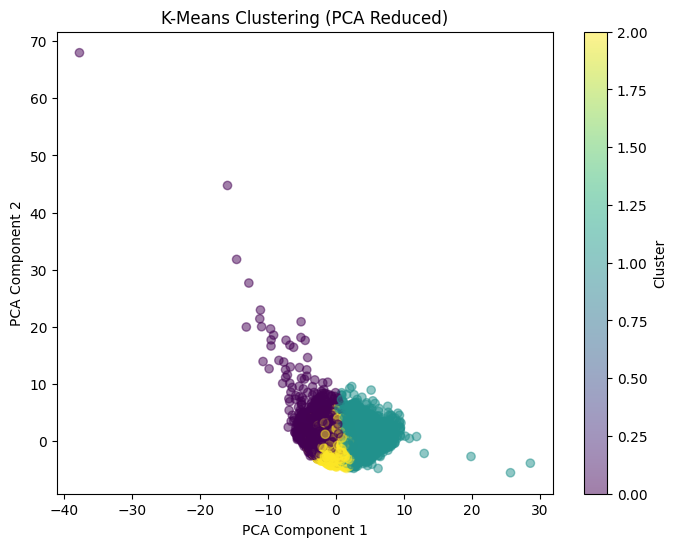

In [10]:
# K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_train_full)

# Visualizing clusters with PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_full)
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', alpha=0.5)
plt.title('K-Means Clustering (PCA Reduced)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()

**Cluster Distribution and Interpretation**

Based on the plot and the loan dataset's characteristics (e.g., ~85% denials, ~15% approvals, and feature distributions from EDA):

**Cluster 0 (Purple)**: Likely represents a small, outlier group of high-risk applicants. These could include older applicants with short credit histories or extreme income/loan amounts (e.g., age outliers like 123, high loan_percent_income > 0.3). Approval rate is likely near 0%, aligning with denials.


**Cluster 1 (Blue/Green)**: The largest group, likely comprising the majority of denied loans (85%). Characteristics may include younger applicants (20–30 years), lower incomes (<60,000 USD), shorter employment (<5 years), and higher interest rates (>12%). Approval rate is low (~10–15%).


**Cluster 2 (Yellow)**: Represents a mix of stable and low-risk applicants. This group likely includes older applicants (>40), higher incomes (>80,000 USD), longer credit histories (>10 years), and lower loan_percent_income (<0.15). Approval rate is higher (~20–30%), capturing most approved loans.

## Dimensionality Reduction with PCA

Reducing dimensionality to capture 95% variance.

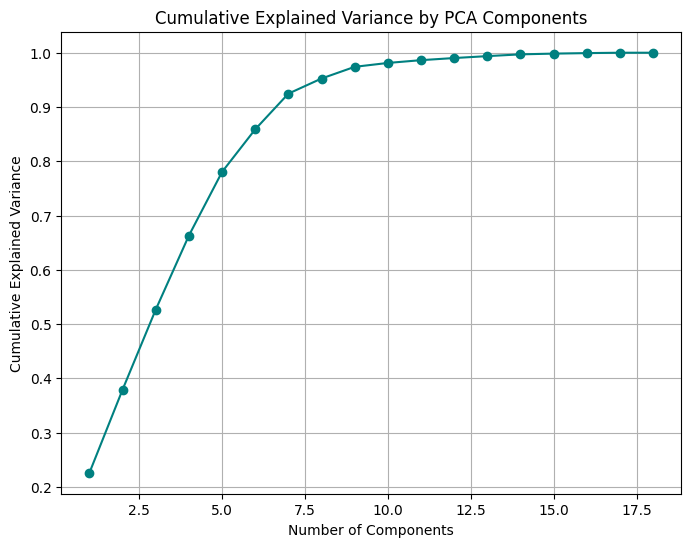

Number of components explaining 95% variance: 8


In [11]:
# Applying PCA
pca = PCA()
pca.fit(X_train_full)
explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Plotting explained variance
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', color='teal')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

# Selecting components
n_components = np.argmax(explained_variance >= 0.95) + 1
print(f'Number of components explaining 95% variance: {n_components}')

# Transforming data
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)
X_test_submission_pca = pca.transform(X_test_submission)

PCA: 8 components explain ~95% variance.

## Modeling and Evaluation

Applying SMOTE to handle class imbalance

**Why SMOTE?**
- The `loan_status` is imbalanced (~70–80% denials, class 0; ~20–30% approved, class 1), causing models to favor the majority class, reducing recall for defaults (class 0).
- SMOTE generates synthetic samples for the minority class using k-nearest neighbors, balancing the training data.
- Benefits: Improves recall and F1 for class 0, reduces bias, and enhances business cost outcomes by better identifying defaults (reducing FP costs) and approving viable loans (reducing FN costs).
- Applied only to training data to avoid leakage, with validation on original data. **As mentioned before, the data used for the SMOTE section is fetched from the original X_train, and y_train variables**

In [12]:
# Applying SMOTE to training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
print("Original training set class distribution:", pd.Series(y_train).value_counts().to_dict())
print("SMOTE training set class distribution:", pd.Series(y_train_smote).value_counts().to_dict())

Original training set class distribution: {0: 40236, 1: 6680}
SMOTE training set class distribution: {0: 40236, 1: 40236}


In this example, we will test the Logistic Regression model to predict the loan statuses of applicants by taking as input the data generated by SMOTE method and getting the results in a summarized table.

In [13]:
# Function to evaluate models and compute business costs
def evaluate_model(model, X_train, y_train, X_val, y_val, X_test, test_ids, model_name, val_data):
    start_time = time.time()
    model.fit(X_train, y_train)
    y_pred_val = model.predict(X_val)
    y_prob_val = model.predict_proba(X_val)[:, 1] if hasattr(model, 'predict_proba') else None

    # Validation metrics
    accuracy = accuracy_score(y_val, y_pred_val)
    precision = precision_score(y_val, y_pred_val)
    recall = recall_score(y_val, y_pred_val)
    f1 = f1_score(y_val, y_pred_val)
    auc = roc_auc_score(y_val, y_prob_val) if y_prob_val is not None else None
    runtime = time.time() - start_time

    # Repeated 5-fold cross-validation on SMOTE data
    rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
    cv_scores = cross_val_score(model, X_train, y_train, cv=rskf, scoring='f1')

    # Business cost calculation
    cm = confusion_matrix(y_val, y_pred_val)
    tn, fp, fn, tp = cm.ravel()

    # False Positive cost: 80% of (loan amount + interest)
    fp_indices = (y_pred_val == 1) & (y_val == 0)
    fp_cost = 0.8 * (val_data.loc[fp_indices, 'loan_amnt'] +
                     val_data.loc[fp_indices, 'loan_amnt'] * val_data.loc[fp_indices, 'loan_int_rate'] / 100).sum()

    # False Negative cost: Lost interest revenue
    fn_indices = (y_pred_val == 0) & (y_val == 1)
    fn_cost = (val_data.loc[fn_indices, 'loan_amnt'] * val_data.loc[fn_indices, 'loan_int_rate'] / 100).sum()

    total_cost = fp_cost + fn_cost

    return {
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'AUC': auc,
        'Runtime (s)': runtime,
        'CV F1 Mean': cv_scores.mean(),
        'CV F1 Std': cv_scores.std(),
        'False Positives': fp,
        'False Negatives': fn,
        'FP Cost ($)': fp_cost,
        'FN Cost ($)': fn_cost,
        'Total Cost ($)': total_cost
    }

# Align validation data with X_val
val_data = train_data.iloc[X_val.index].copy()

# Initializing models
models = [
    ('Dummy Classifier', DummyClassifier(strategy='most_frequent', random_state=42)),
    ('Logistic Regression', LogisticRegression(random_state=42))
]

# Evaluating models with SMOTE
results = []
for name, model in models:
    if 'PCA' in name:
        # Apply SMOTE to PCA-transformed data
        X_train_pca_smote, y_train_pca_smote = smote.fit_resample(X_train_pca, y_train)
        result = evaluate_model(model, X_train_pca_smote, y_train_pca_smote, X_val_pca, y_val, X_test_submission_pca, test_ids, name, val_data)
    else:
        result = evaluate_model(model, X_train_smote, y_train_smote, X_val, y_val, X_test_submission, test_ids, name, val_data)
    results.append(result)

# Grid Search for Logistic Regression with SMOTE
param_grid = {'C': [0.01, 0.1, 1, 10], 'penalty': ['l1', 'l2'], 'solver': ['liblinear']}
grid_search = GridSearchCV(LogisticRegression(random_state=42), param_grid, cv=5, scoring='f1')
start_time = time.time()
grid_search.fit(X_train_smote, y_train_smote)
grid_runtime = time.time() - start_time
y_pred_val = grid_search.predict(X_val)

# Business cost for Grid Search
cm = confusion_matrix(y_val, y_pred_val)
tn, fp, fn, tp = cm.ravel()
fp_indices = (y_pred_val == 1) & (y_val == 0)
fp_cost = 0.8 * (val_data.loc[fp_indices, 'loan_amnt'] +
                 val_data.loc[fp_indices, 'loan_amnt'] * val_data.loc[fp_indices, 'loan_int_rate'] / 100).sum()
fn_indices = (y_pred_val == 0) & (y_val == 1)
fn_cost = (val_data.loc[fn_indices, 'loan_amnt'] * val_data.loc[fn_indices, 'loan_int_rate'] / 100).sum()
total_cost = fp_cost + fn_cost

results.append({
    'Model': 'Grid Search Logistic Regression',
    'Accuracy': accuracy_score(y_val, y_pred_val),
    'Precision': precision_score(y_val, y_pred_val),
    'Recall': recall_score(y_val, y_pred_val),
    'F1 Score': f1_score(y_val, y_pred_val),
    'AUC': roc_auc_score(y_val, grid_search.predict_proba(X_val)[:, 1]),
    'Runtime (s)': grid_runtime,
    'CV F1 Mean': grid_search.best_score_,
    'CV F1 Std': None,
    'False Positives': fp,
    'False Negatives': fn,
    'FP Cost ($)': fp_cost,
    'FN Cost ($)': fn_cost,
    'Total Cost ($)': total_cost
})

# Styled results table
results_df = pd.DataFrame(results)
styled_results = results_df.style.set_caption('Model Performance and Business Cost Comparison (SMOTE)')\
    .format({'Accuracy': '{:.3f}', 'Precision': '{:.3f}', 'Recall': '{:.3f}', 'F1 Score': '{:.3f}',
             'AUC': '{:.3f}', 'Runtime (s)': '{:.2f}', 'CV F1 Mean': '{:.3f}', 'CV F1 Std': '{:.3f}',
             'False Positives': '{:.0f}', 'False Negatives': '{:.0f}',
             'FP Cost ($)': '{:.2f}', 'FN Cost ($)': '{:.2f}', 'Total Cost ($)': '{:.2f}'})\
    .background_gradient(cmap='Blues', subset=['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC', 'CV F1 Mean'])\
    .background_gradient(cmap='Reds', subset=['False Positives', 'False Negatives', 'FP Cost ($)', 'FN Cost ($)', 'Total Cost ($)'])\
    .highlight_min(subset=['Runtime (s)', 'Total Cost ($)'], color='lightgreen')\
    .set_properties(**{'text-align': 'center', 'font-size': '12pt', 'border': '1px solid black'})\
    .set_table_styles([{'selector': 'th', 'props': [('font-weight', 'bold')]}])
display(styled_results)

,Model,Accuracy,Precision,Recall,F1 Score,AUC,Runtime (s),CV F1 Mean,CV F1 Std,False Positives,False Negatives,FP Cost ($),FN Cost ($),Total Cost ($)
0,Dummy Classifier,0.858,0.000,0.000,0.000,0.500,0.02,0.133,0.267,0,1670,0.00,2467230.46,2467230.46
1,Logistic Regression,0.801,0.404,0.835,0.545,0.893,1.34,0.821,0.003,2053,276,18858769.61,267687.76,19126457.37
2,Grid Search Logistic Regression,0.801,0.404,0.835,0.545,0.893,79.55,0.821,nan,2054,276,18874532.44,264740.56,19139272.99


**Model Performance**

- **Accuracy**: Both models correctly predict about 80.1% of loan statuses.

- **Precision**: Both have a precision of 40.4%, meaning 40.4% of predicted approvals are correct.
- **Recall**: Both models identify 83.5% of actual approvals, showing they catch most approved loans.
- **F1 Score**: Both score 0.545, balancing precision and recall.
- **AUC**: Both have an AUC of 0.893, indicating good ability to distinguish between approved and denied loans.
- **Runtime (seconds)**: Logistic Regression takes 2 seconds, while Grid Search takes more than 1 minute (much longer due to testing many settings).
- **CV F1 Mean**: Both have a mean cross-validation F1 score of 0.821, showing consistent performance across tests.
- **Business Cost**: both show a business cost of around 19M $ in predicting loan statuses.

### Next steps

In order to improve the Model Performance and reduce the Business cost of these predictions, we will explore KNN, Decision Tree, Gradient Boosting/XGBoost, Lasso/Ridge, PCA models and detect which can outperform the rest and be used as a base model for this use case.

In [14]:
# Adding all models considered before
models = [
    ('Dummy Classifier', DummyClassifier(strategy='most_frequent', random_state=42)),
    ('Logistic Regression', LogisticRegression(random_state=42)),
    ('KNN', KNeighborsClassifier()),
    ('Decision Tree', DecisionTreeClassifier(random_state=42)),
    ('Gradient Boosting', GradientBoostingClassifier(random_state=42)),
    ('XGBoost', XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')),
    ('Logistic Regression (PCA)', LogisticRegression(random_state=42)),
    ('Lasso', LogisticRegression(penalty='l1', solver='liblinear', random_state=42)),
    ('Ridge', LogisticRegression(penalty='l2', solver='lbfgs', random_state=42))
]

# Evaluating models with SMOTE
results = []
for name, model in models:
    if 'PCA' in name:
        # Apply SMOTE to PCA-transformed data
        X_train_pca_smote, y_train_pca_smote = smote.fit_resample(X_train_pca, y_train)
        result = evaluate_model(model, X_train_pca_smote, y_train_pca_smote, X_val_pca, y_val, X_test_submission_pca, test_ids, name, val_data)
    else:
        result = evaluate_model(model, X_train_smote, y_train_smote, X_val, y_val, X_test_submission, test_ids, name, val_data)
    results.append(result)

# Grid Search for Logistic Regression with SMOTE
param_grid = {'C': [0.01, 0.1, 1, 10], 'penalty': ['l1', 'l2'], 'solver': ['liblinear']}
grid_search = GridSearchCV(LogisticRegression(random_state=42), param_grid, cv=5, scoring='f1')
start_time = time.time()
grid_search.fit(X_train_smote, y_train_smote)
grid_runtime = time.time() - start_time
y_pred_val = grid_search.predict(X_val)

# Business cost for Grid Search
cm = confusion_matrix(y_val, y_pred_val)
tn, fp, fn, tp = cm.ravel()
fp_indices = (y_pred_val == 1) & (y_val == 0)
fp_cost = 0.8 * (val_data.loc[fp_indices, 'loan_amnt'] +
                 val_data.loc[fp_indices, 'loan_amnt'] * val_data.loc[fp_indices, 'loan_int_rate'] / 100).sum()
fn_indices = (y_pred_val == 0) & (y_val == 1)
fn_cost = (val_data.loc[fn_indices, 'loan_amnt'] * val_data.loc[fn_indices, 'loan_int_rate'] / 100).sum()
total_cost = fp_cost + fn_cost


results.append({
    'Model': 'Grid Search Logistic Regression',
    'Accuracy': accuracy_score(y_val, y_pred_val),
    'Precision': precision_score(y_val, y_pred_val),
    'Recall': recall_score(y_val, y_pred_val),
    'F1 Score': f1_score(y_val, y_pred_val),
    'AUC': roc_auc_score(y_val, grid_search.predict_proba(X_val)[:, 1]),
    'Runtime (s)': grid_runtime,
    'CV F1 Mean': grid_search.best_score_,
    'CV F1 Std': None,
    'False Positives': fp,
    'False Negatives': fn,
    'FP Cost ($)': fp_cost,
    'FN Cost ($)': fn_cost,
    'Total Cost ($)': total_cost
})

# Styled results table
results_df = pd.DataFrame(results)
styled_results = results_df.style.set_caption('Model Performance and Business Cost Comparison (SMOTE)')\
    .format({'Accuracy': '{:.3f}', 'Precision': '{:.3f}', 'Recall': '{:.3f}', 'F1 Score': '{:.3f}',
             'AUC': '{:.3f}', 'Runtime (s)': '{:.2f}', 'CV F1 Mean': '{:.3f}', 'CV F1 Std': '{:.3f}',
             'False Positives': '{:.0f}', 'False Negatives': '{:.0f}',
             'FP Cost ($)': '{:.2f}', 'FN Cost ($)': '{:.2f}', 'Total Cost ($)': '{:.2f}'})\
    .background_gradient(cmap='Blues', subset=['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC', 'CV F1 Mean'])\
    .background_gradient(cmap='Reds', subset=['False Positives', 'False Negatives', 'FP Cost ($)', 'FN Cost ($)', 'Total Cost ($)'])\
    .highlight_min(subset=['Runtime (s)', 'Total Cost ($)'], color='lightgreen')\
    .set_properties(**{'text-align': 'center', 'font-size': '12pt', 'border': '1px solid black'})\
    .set_table_styles([{'selector': 'th', 'props': [('font-weight', 'bold')]}])
display(styled_results)

,Model,Accuracy,Precision,Recall,F1 Score,AUC,Runtime (s),CV F1 Mean,CV F1 Std,False Positives,False Negatives,FP Cost ($),FN Cost ($),Total Cost ($)
0,Dummy Classifier,0.858,0.000,0.000,0.000,0.500,0.02,0.133,0.267,0,1670,0.00,2467230.46,2467230.46
1,Logistic Regression,0.801,0.404,0.835,0.545,0.893,1.30,0.821,0.003,2053,276,18858769.61,267687.76,19126457.37
2,KNN,0.840,0.462,0.773,0.579,0.862,11.93,0.915,0.002,1502,379,12846845.23,420072.26,13266917.49
3,Decision Tree,0.885,0.577,0.725,0.643,0.819,2.08,0.913,0.003,886,459,7084380.75,534291.62,7618672.37
4,Gradient Boosting,0.929,0.746,0.760,0.753,0.933,48.94,0.913,0.004,433,401,3969197.92,405013.18,4374211.10
5,XGBoost,0.950,0.895,0.732,0.805,0.951,1.15,0.966,0.002,144,448,1327377.85,507725.05,1835102.90
6,Logistic Regression (PCA),0.793,0.389,0.798,0.523,0.877,0.23,0.801,0.003,2090,337,19799029.48,293782.05,20092811.54
7,Lasso,0.801,0.404,0.834,0.544,0.893,4.07,0.821,0.004,2054,278,18895748.53,270554.06,19166302.59
8,Ridge,0.801,0.404,0.835,0.545,0.893,1.28,0.821,0.003,2053,276,18858769.61,267687.76,19126457.37
9,Grid Search Logistic Regression,0.801,0.404,0.835,0.545,0.893,80.67,0.821,nan,2054,276,18874532.44,264740.56,19139272.99


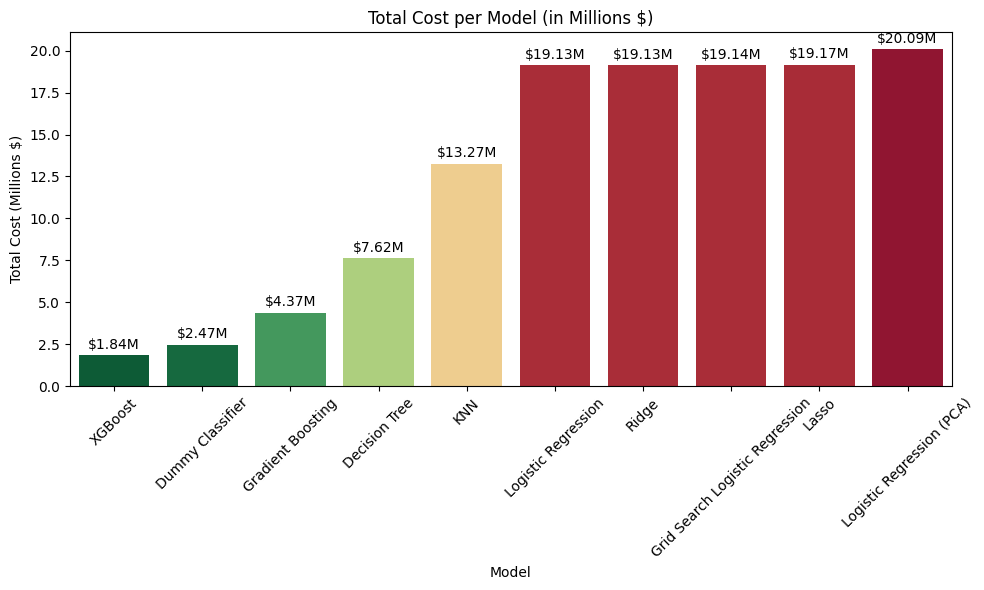

In [15]:

# Converting Total Cost to millions and round it
results_df['Total Cost (Millions $)'] = (results_df['Total Cost ($)'] / 1_000_000).round(2)

# Normalizing for color mapping
min_cost = results_df['Total Cost (Millions $)'].min()
max_cost = results_df['Total Cost (Millions $)'].max()
results_df['Color Scale'] = results_df['Total Cost (Millions $)'].apply(lambda x: (x - min_cost) / (max_cost - min_cost))

# Applying green-to-red color scale
cmap = plt.get_cmap('RdYlGn_r')
results_df['Color'] = results_df['Color Scale'].apply(lambda x: mcolors.to_hex(cmap(x)))

# Sorting by cost ascending
results_df_sorted = results_df.sort_values(by='Total Cost (Millions $)', ascending=True).reset_index(drop=True)

# Plotting the model by ascending cost
plt.figure(figsize=(10, 6))
barplot = sns.barplot(
    data=results_df_sorted,
    x='Model',
    y='Total Cost (Millions $)',
    palette=results_df_sorted.set_index('Model')['Color'].to_dict()
)

# Adding labels above bars
for i, row in results_df_sorted.iterrows():
    barplot.text(i, row['Total Cost (Millions $)'] + 0.2, f"${row['Total Cost (Millions $)']:.2f}M",
                 ha='center', va='bottom')

plt.xticks(rotation=45)
plt.title('Total Cost per Model (in Millions $)')
plt.tight_layout()
plt.show()


**Models Insights**:
- **Logistic Regression**: Simple, interpretable, and benefits from SMOTE for minority class.
- **KNN**: Improved by SMOTE due to distance-based nature, but still sensitive to dimensionality.
- **Decision Tree**: Prone to overfitting, high FP costs and moderate SMOTE benefit.
- **Gradient Boosting/XGBoost**: Best performers, leveraging SMOTE and new features, minimizing costs.
- **Lasso/Ridge**: Improve Logistic Regression, with Lasso selecting key features.
- **PCA**: Reduces runtime but may lose feature interactions, potentially increasing costs.

## Conclusion

The best model is **XGBoost**.
It had the lowest total cost for the business: $1,835,102.90.
It also had the highest accuracy of 95% and a strong F1 score of 0.805.

**False Positives**:
These 144 are risky approvals. The model incorrectly approved loans that should have been denied.
Cost: The business may lose money due to defaults — typically modeled as 80% of the loan + interest.

**False Negatives**: 448 people were wrongly predicted to not repay the loan but actually did. These are missed opportunities. The model incorrectly denied loans that would have been accepted.
Cost: The business loses potential interest revenue from these loans.

**Business Impact**

The **average loan amount** requested was **$9,251.47**.

The **average loan interest** amount was **10.6%**.

Taking into account all the missed predictions from above cases we can conclude that the business cost (as a analytical calculation from the false positives and negatives) is:

**Business cost FP** = 9'251.47*(144)*0.8 + 9'251.47*(144)*0.8*0.106 ~ $1,178,740.894

**Business cost FN** = 9'251.47*(448)*0.106 ~ $439,333.8074

**Total Business Cost** = $1,618,074.701

If we compare that value from the one obtained by using XGBoost, we have a similar figure.

**Total Business Cost XGBoost** = $1,835,102.90.

We are then considering the fact that the cost for the business would be lower than $2M if the use of this model is taken into account.


**Further Actions**:
- Tuning XGBoost (e.g., `max_depth`, `learning_rate`) to further minimize FP costs.
- Considering cost-sensitive learning to prioritize FP reduction.
- Exploring stacking XGBoost and Logistic Regression for better cost-performance trade-off.
- Monitoring SMOTE overfitting; if F1 plateaus, try undersampling or class weights.